# ML Models with more features

## Reading the csv document

In [1]:
# We have a list of game with this features;

#Name,Platform,Year_of_Release,Genre,Publisher,
#NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,
#Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating

#We want to predict the global_sales using all the other features.

#First of all, we have to delete all the features related with sales, because if not, the model will always relate the global_sales
#with all the other sells.

#Should we use the user_score and the user_count? We can't know the result features related with users before the release of the game

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../../../data/vgsales_metacritic_total.csv") #decomment this line if you are not using googleColab locally

#Using google colab
#from google.colab import files
#uploaded = files.upload() #comment this line after the first execution 
#import io
#df = pd.read_csv(io.BytesIO(uploaded['vgsales_metacritic_total.csv'])) #googleColab. Comment this line if you are executing locally
#We save this only to show the plots
Developer = df['Developer'].fillna('unknown')
Publisher = df['Publisher'].fillna('unknown')



In [2]:
import ast
df['Genres'] = df['Genres'].fillna("['unknown']")
for i in range(len(df['Genres'])):
    df['Genres'][i] = ast.literal_eval(str(df['Genres'][i]))
print(df['Genres'])

<ipython-input-2-5606e728472e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genres'][i] = ast.literal_eval(str(df['Genres'][i]))


0        [Sports, General, General, Individual, Athletics]
1                                                [unknown]
2        [Driving, Racing, Arcade, Kart, Kart, Automobile]
3        [Sports, General, General, Individual, Athletics]
4                                                [unknown]
                               ...                        
18891             [Simulation, Flight, WWII, WWII, Combat]
18892          [Action Adventure, Modern, General, Modern]
18893                                            [unknown]
18894                                            [unknown]
18895                                            [unknown]
Name: Genres, Length: 18896, dtype: object


# Checking and treating missing values 

In [3]:
#We are not going to use User_Count, User_Score, Publisher, Developer and sales different than global_Sales, so we just delete them form the db
Global_Sales_ = df['Global_Sales']

dummies = pd.get_dummies(df.Genres.apply(pd.Series).stack()).sum(level=0)
print(len(dummies.columns))
#df = pd.concat([df, dummies], axis=1)
df = df.drop(['Genres','Rank','Name','User_Score','User_count','User_score','Critic_Score','NA_Sales','PAL_Sales','JP_Sales','Other_Sales','Publisher','Developer','Url_name'], axis=1)

print(df.columns)

168
Index(['Platform', 'Year', 'Genre', 'Global_Sales', 'Critic_score',
       'Critic_count', 'Rating'],
      dtype='object')


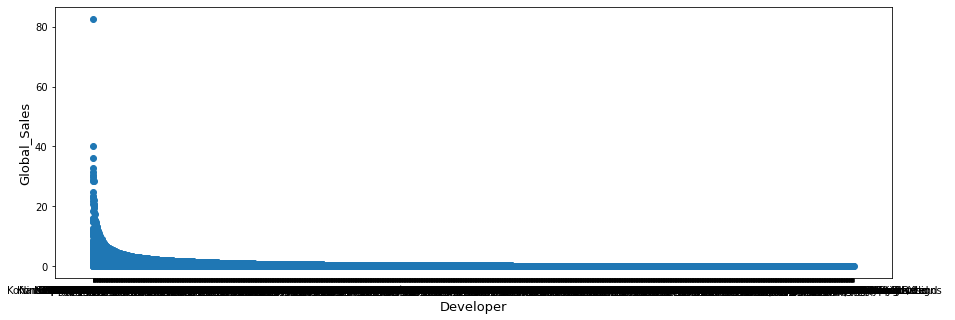

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = Developer, y = Global_Sales_)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Developer', fontsize=13)
plt.show()

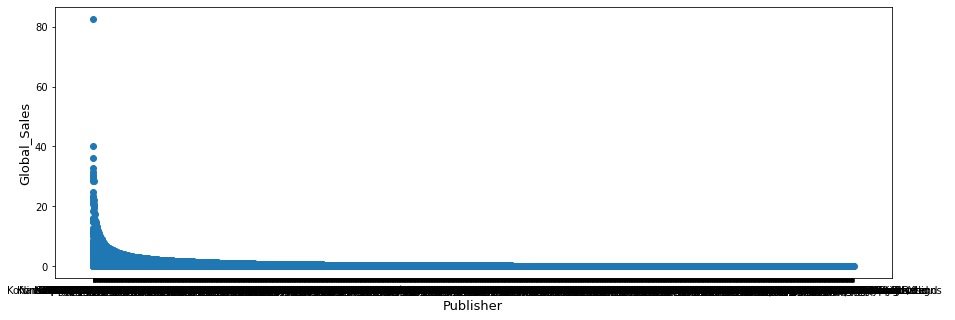

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = Developer, y = Global_Sales_)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Publisher', fontsize=13)
plt.show()

In [6]:
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

Missing Ratio
Critic_score      54.355419
Critic_count      54.355419
Rating            43.570068
Year               0.306943

Critic_Score is our most important feature but also the feature with the highest missing ratio. As we can see, the ratio is exactly the same as Critic_Count, which it makes sense. If we treat one of them, we are going to treat both.

We decide to treat them deleting the rows, because if the missing ratio is that high, it doesn't make any sense to try to use Knn imputer to predict the Critic_Score and Critic_Count because we don't have enough values.

In [7]:
df = df.dropna(subset=['Critic_score'])

#Lets see the missing ratios again
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

Missing Ratio
Rating       0.950725
Year         0.139130

To create a realistic models, we are going to delete all the Platform that are not used anymore

In [8]:
df = df[(df['Platform'] == 'PS3') | (df['Platform'] == 'PS4') | (df['Platform'] == 'X360') | (df['Platform'] == 'XOne') 
        | (df['Platform'] == 'Wii') | (df['Platform'] == 'WiiU') | (df['Platform'] == 'PC')]

In [9]:
#Lets see the missing ratios again
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

Missing Ratio
Rating       1.756955
Year         0.195217

In [10]:
from sklearn.impute import KNNImputer
print(df.head())
Year = df.iloc[:,1]
Rating = df.iloc[:,5]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df['Year'] = imputer.fit_transform(Year.values.reshape(-1, 1))
df['Rating'] = df['Rating'].fillna(df['Rating'].mode()[0])


  Platform    Year     Genre  Global_Sales  Critic_score  Critic_count Rating
0      Wii  2006.0    Sports         82.65          76.0          51.0      E
2      Wii  2008.0    Racing         35.98          82.0          73.0      E
3      Wii  2009.0    Sports         32.90          80.0          73.0      E
7      Wii  2007.0      Misc         28.92          58.0          41.0      E
8      Wii  2009.0  Platform         28.51          87.0          80.0      E


In [11]:
#Lets see the missing ratios again
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

print(df.columns)

Index(['Platform', 'Year', 'Genre', 'Global_Sales', 'Critic_score',
       'Critic_count', 'Rating'],
      dtype='object')


# Plotting the data

In [12]:
Platform = df.iloc[:,0]
Year = df.iloc[:,1]
Genre = df.iloc[:,2]
Global_Sales = df.iloc[:,3]
Critic_Score = df.iloc[:,4]
Critic_Count = df.iloc[:,5]
Rating = df.iloc[:,6]

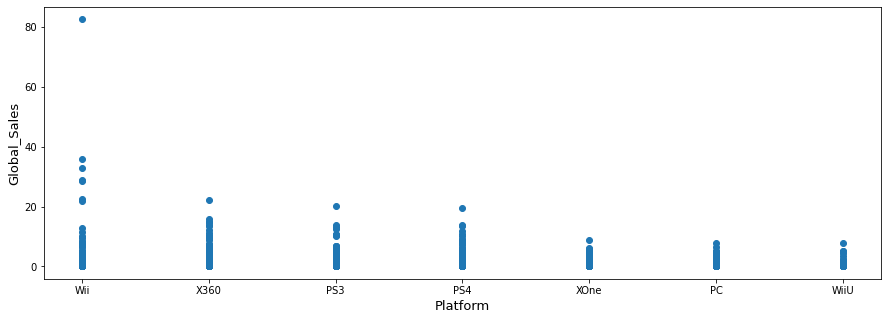

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = Platform, y = Global_Sales)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Platform', fontsize=13)
plt.show()

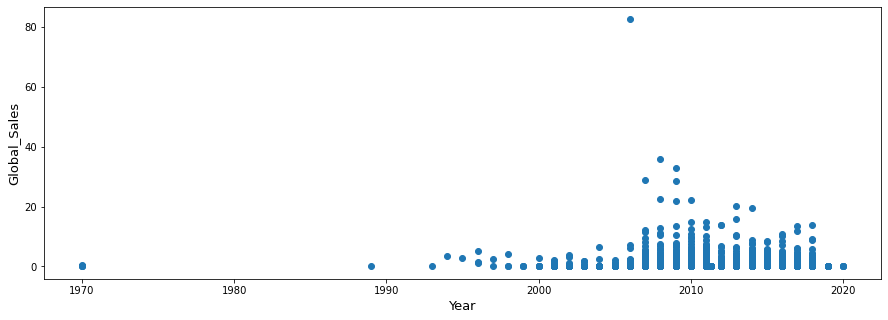

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = Year, y = Global_Sales)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.show()

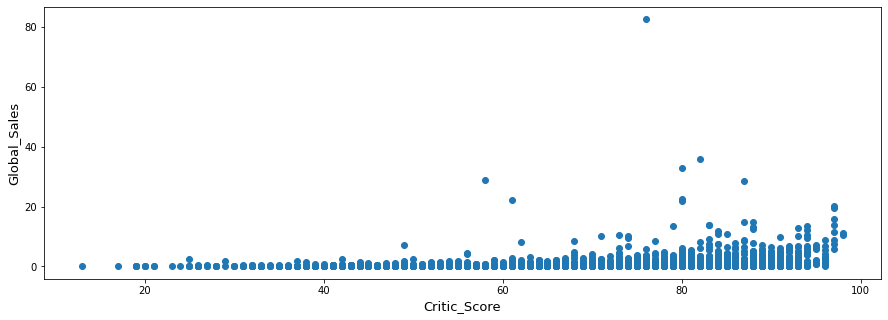

In [15]:
import matplotlib.pyplot as plt
df_aux = df[['Critic_score', 'Global_Sales']]
critic_df = df_aux.dropna()
critic_aux = critic_df.iloc[:,0]
globalSales_aux = critic_df.iloc[:,1]
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = critic_aux, y = globalSales_aux)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

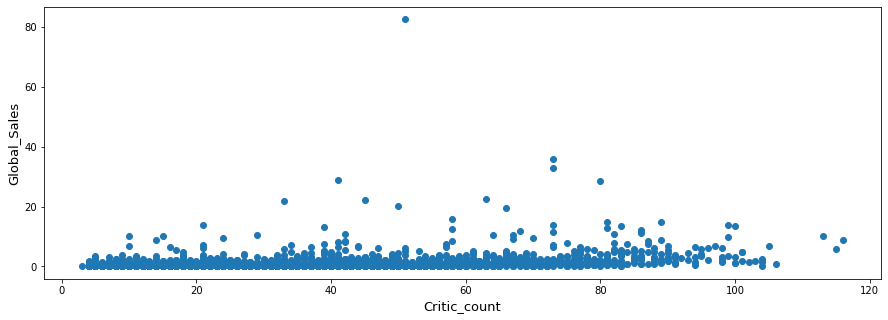

In [16]:
import matplotlib.pyplot as plt
df_aux = df[['Critic_count', 'Global_Sales']]
critic_df = df_aux.dropna()
critic_aux = critic_df.iloc[:,0]
globalSales_aux = critic_df.iloc[:,1]
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = critic_aux, y = globalSales_aux)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_count', fontsize=13)
plt.show()

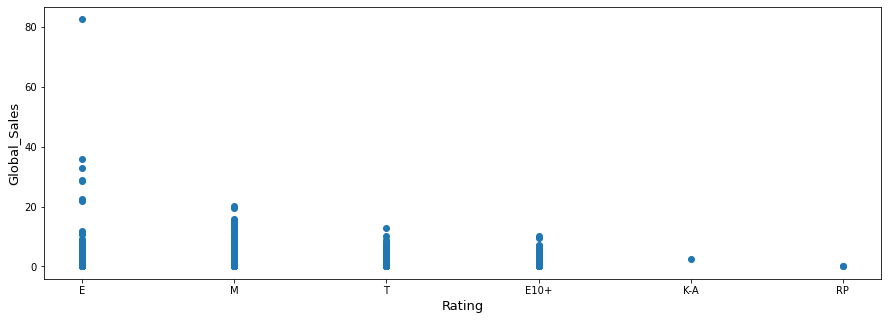

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x = Rating, y = Global_Sales)
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Rating', fontsize=13)
plt.show()

# Encoding string inputs

In [18]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

Platform = lb.fit_transform(Platform)
Genre = lb.fit_transform(Genre)
Rating = lb.fit_transform(Rating)


# Splitting the DB

In [308]:
from sklearn.model_selection import train_test_split


inputs = np.column_stack((Platform,Year,Genre,Critic_Score,Critic_Count,Rating))
output = Global_Sales

Xtrain, Xtest, ytrain, ytest = train_test_split(inputs, output)

## Linear Regression model

In [309]:
from sklearn.linear_model import LinearRegression
# all parameters not specified are set to their defaults
linearRegr = LinearRegression()

#Model is learning the relationship between digits (x_train) and labels (y_train)
linearRegr.fit(Xtrain, ytrain)
coef = linearRegr.coef_
intercept = linearRegr.intercept_

# Use score method to get accuracy of model
ypred = linearRegr.predict(Xtest)


In [310]:
from sklearn.metrics import r2_score , mean_squared_error
score = r2_score(ytest, ypred)

print("r2 score: ", score)

score = mean_squared_error(ytest, ypred)

print("mean squared error regression loss: ", score)


r2 score:  0.2468783278102138
mean squared error regression loss:  1.6709848914992345


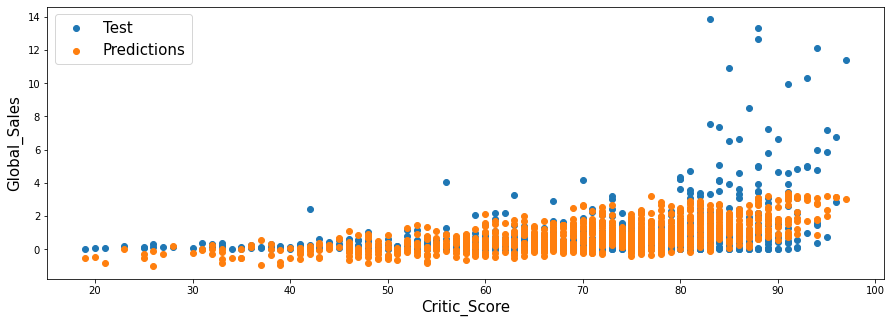

In [311]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(x = Xtest[:,3], y = ytest,label='Test')
ax.scatter(x = Xtest[:,3], y = ypred,label='Predictions')
plt.ylabel('Global_Sales', fontsize=15)
plt.xlabel('Critic_Score', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

# SVM model


In this case we have to use the support vector regression

In [312]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

SVR_grid = [
    {'C': [10,100,200], 'gamma': [0.0001, 0.001, 0.01]}
]

SVR_gridSearch = GridSearchCV(SVR(), SVR_grid, cv=5, scoring='r2')
SVR_gridSearch.fit(Xtrain, ytrain)
print("Best parameters: {}".format(SVR_gridSearch.best_params_))

Best parameters: {'C': 100, 'gamma': 0.001}


In [348]:
C_range = range(1,300,50)

scores_list = []
mean_list = []
for i in C_range:
    regressionSVM = SVR(C = i,gamma=0.001)
    regressionSVM.fit(Xtrain,ytrain)
    pred=regressionSVM.predict(Xtest)
    scores_list.append(r2_score(ytest,pred))
    mean_list.append(mean_squared_error(ytest,pred))

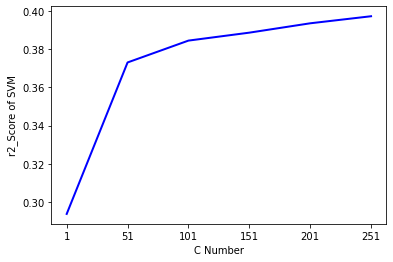

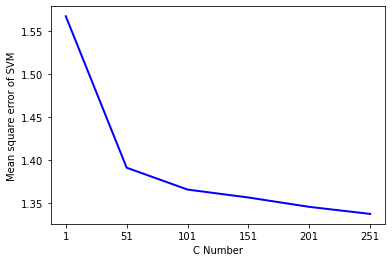

In [349]:
plot1 = plt.figure(1)
plt.plot(C_range, scores_list, linewidth=2, color='blue')
plt.xticks(C_range)
plt.xlabel('C Number')
plt.ylabel('r2_Score of SVM')

plot2 = plt.figure(2)
plt.plot(C_range, mean_list, linewidth=2, color='blue')
plt.xticks(C_range)
plt.xlabel('C Number')
plt.ylabel('Mean square error of SVM')


plt.show()   

In [350]:
from sklearn.svm import SVR
from sklearn import utils


# all parameters not specified are set to their defaults
regressionSVM = SVR(C=51,gamma=0.001)


#Model is learning the relationship between digits (Xtrain) and labels (training_scores_encoded)
regressionSVM.fit(Xtrain, ytrain)

# Use score method to get accuracy of model
ypred = regressionSVM.predict(Xtest)

In [351]:
from sklearn.metrics import r2_score , mean_squared_error

score = r2_score(ytest, ypred)

print("r2 score: ", score)

score = mean_squared_error(ytest, ypred)

print("mean squared error regression loss: ", score)

r2 score:  0.37300468691395006
mean squared error regression loss:  1.391142671756234


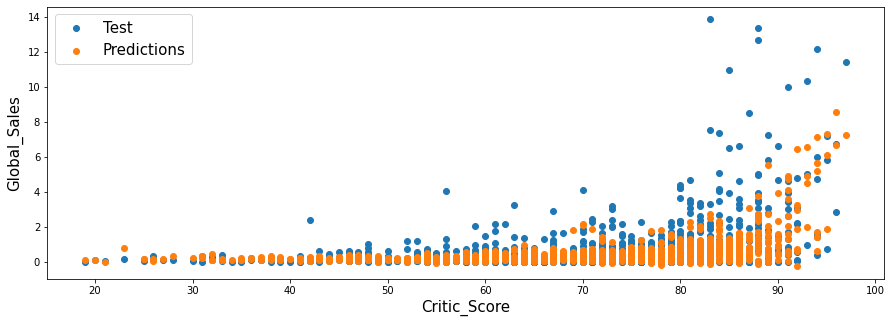

In [352]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(x = Xtest[:,3], y = ytest,label='Test')
ax.scatter(x = Xtest[:,3], y = ypred,label='Predictions')
plt.ylabel('Global_Sales', fontsize=15)
plt.xlabel('Critic_Score', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## K-Nearest Neighbour

In [318]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

KNN_grid = [
    {'n_neighbors': [1, 3, 5, 10,20,50,75,100,120,200], 'weights': ['uniform','distance']}
]

KNN_gridSearch = GridSearchCV(KNeighborsRegressor(), KNN_grid, cv=5, scoring='r2')
KNN_gridSearch.fit(Xtrain, ytrain)
print("Best parameters:", KNN_gridSearch.best_params_)

Best parameters: {'n_neighbors': 120, 'weights': 'distance'}


In [331]:
k_range = range(5,120,5)

scores_list = []
mean_list = []
for i in k_range:
    regressor_knn = KNeighborsRegressor(n_neighbors = i, weights='distance')
    regressor_knn.fit(Xtrain,ytrain)
    pred=regressor_knn.predict(Xtest)
    scores_list.append(r2_score(ytest,pred))
    mean_list.append(mean_squared_error(ytest,pred))

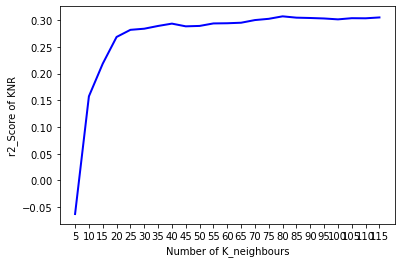

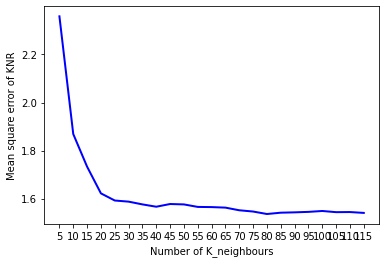

In [333]:
plot1 = plt.figure(1)
plt.plot(k_range, scores_list, linewidth=2, color='blue')
plt.xticks(k_range)
plt.xlabel('Number of K_neighbours')
plt.ylabel('r2_Score of KNR')

plot2 = plt.figure(2)
plt.plot(k_range, mean_list, linewidth=2, color='blue')
plt.xticks(k_range)
plt.xlabel('Number of K_neighbours')
plt.ylabel('Mean square error of KNR')


plt.show()   

In [336]:
knnModel = KNeighborsRegressor(n_neighbors=20,weights='distance')

#Model is learning the relationship between digits (Xtrain) and labels (training_scores_encoded)
knnModel.fit(Xtrain, ytrain)

# Use score method to get accuracy of model
ypred = knnModel.predict(Xtest)

In [337]:
from sklearn.metrics import r2_score , mean_squared_error

score = r2_score(ytest, ypred)

print("r2 score: ", score)

score = mean_squared_error(ytest, ypred)

print("mean squared error regression loss: ", score)

r2 score:  0.3005293221648432
mean squared error regression loss:  1.5519470198100174


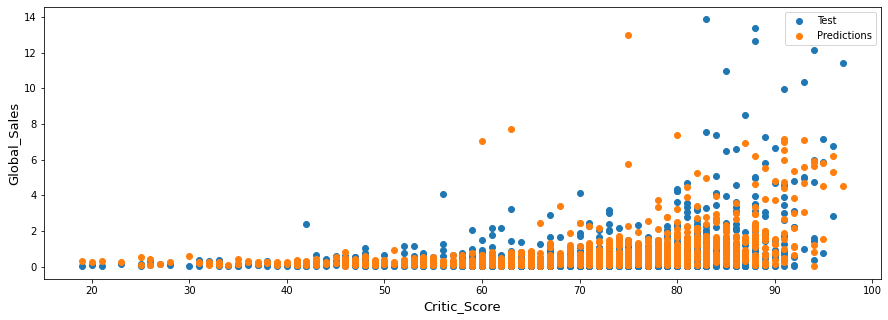

In [323]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(x = Xtest[:,3], y = ytest,label='Test')
ax.scatter(x = Xtest[:,3], y = ypred,label='Predictions')
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.legend()
plt.show()

# Random Forest regressor


In [324]:
max_depth = [50,60,70]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Number of trees in random forest
n_estimators = [50,100,150]
max_features= ['auto','sqrt']

In [325]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
RFR_grid = [
    {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
]

RFR_gridSearch = GridSearchCV(RandomForestRegressor(), RFR_grid, cv=5, scoring='r2')
RFR_gridSearch.fit(Xtrain, ytrain)
print("Best parameters:", RFR_gridSearch.best_params_)

#Using RandomizedSearchCV
#Best parameters: {'n_estimators': 892, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}

Best parameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [353]:
N_range = range(24,200,5)

scores_list = []
mean_list = []
predictions = []
for i in N_range:
    regressor_RFR = RandomForestRegressor(n_estimators = i, min_samples_split = 2, max_features= 'sqrt',max_depth= 50,min_samples_leaf= 3)
    regressor_RFR.fit(Xtrain,ytrain)
    pred=regressor_RFR.predict(Xtest)
    predictions.append(pred)
    scores_list.append(r2_score(ytest,pred))
    mean_list.append(mean_squared_error(ytest,pred))
    
maxScore = max(scores_list)
index = scores_list.index(maxScore)
ypred = predictions[index]
print(maxScore)
print(max(mean_list))

0.378044363753524
1.6611807451606835


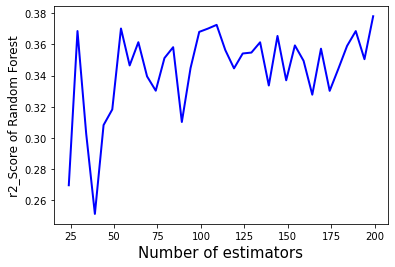

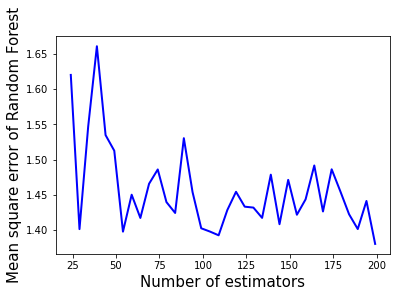

In [354]:
plot1 = plt.figure(1)
plt.plot(N_range, scores_list, linewidth=2, color='blue')

plt.xlabel('Number of estimators',fontsize=15)
plt.ylabel('r2_Score of Random Forest',fontsize=12)

plot2 = plt.figure(2)
plt.plot(N_range, mean_list, linewidth=2, color='blue')
plt.xlabel('Number of estimators',fontsize=15)
plt.ylabel('Mean square error of Random Forest',fontsize=15)


plt.show()      

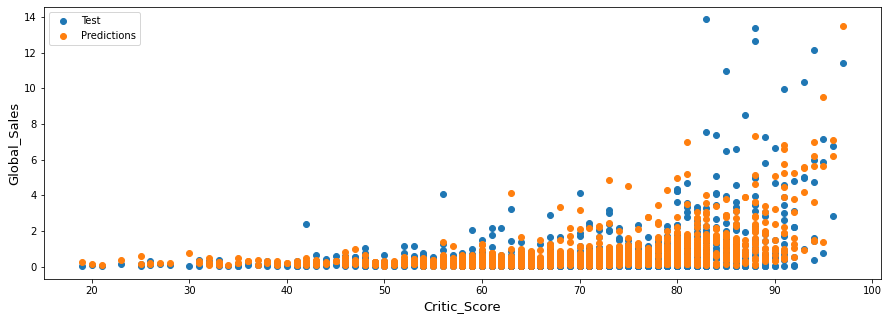

In [355]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(x = Xtest[:,3], y = ytest,label='Test')
ax.scatter(x = Xtest[:,3], y = ypred,label='Predictions')
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.legend()
plt.show()


# Dummy Regressor

In [266]:
from sklearn.dummy import DummyRegressor

dummyModel = DummyRegressor(strategy='mean')

#Model is learning the relationship between digits (Xtrain) and labels
dummyModel.fit(Xtrain, ytrain)

# Use score method to get accuracy of model
ypred = dummyModel.predict(Xtest)

In [267]:
from sklearn.metrics import r2_score , mean_squared_error

score = r2_score(ytest, ypred)

print("r2 score: ", score)

score = mean_squared_error(ytest, ypred)

print("mean squared error regression loss: ", score)

r2 score:  -0.00018788758458065935
mean squared error regression loss:  3.0666704976355943


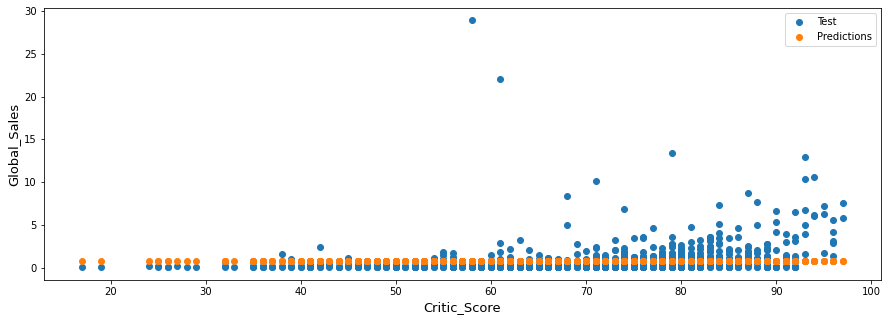

In [268]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(x = Xtest[:,3], y = ytest,label='Test')
ax.scatter(x = Xtest[:,3], y = ypred,label='Predictions')
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.legend()
plt.show()